## 環境

請填寫當前執行使用的環境。

|環境|名稱|版本|
|-|-|-|
|作業系統|Ubuntu|18.04 LTS|
|程式執行環境|colab||
|python 版本|python3|3.6.9|
|安裝環境|pip|20.0.2|

## 安裝

請填寫安裝套件需要的指令

```sh
pip install -r requirements.txt
```

## 計算資源

|計算資源|答案|
|-|-|
|使用 CPU 核心數|1|
|記憶體需求|$\leq 1$GB|
|有無使用 GPU|無|
|GPU 版本|無|
|GPU 記憶體需求|$\leq 1$GB|

## 參考資源

- 有無參考他人之實驗結果：有
- 有參考作業2的程式碼

## 參考網址
- https://datatofish.com/correlation-matrix-pandas/
- https://www.displayr.com/what-is-a-correlation-matrix/
- https://stackoverflow.com/questions/35873273/display-cluster-labels-for-a-scipy-dendrogram
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
- https://www.kaggle.com/aryan19/clustering-google-travel-ratings

# Colab 前置處理(一定要先執行以下所有程式)

- 取得雲端存取權限
  - 會出現網址要求登入(2次)，此時要把驗證碼複製並貼回。
- 建立相關暫存資料夾
- 將目錄移至FDA_HW3_2_F64051164
- 下載套件

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144439 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p Drive
!google-drive-ocamlfuse Drive

In [0]:
import os
#將資料目錄移至FDA_HW3_2_F64051164
os.chdir("Drive/Colab Notebooks/FDA_HW3_2_F64051164")

In [4]:
pip install -r requirements.txt

     |████████████████████████████████| 20.2MB 5.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


In [5]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

EXECUTION_START_TIME = time.time() # 計算執行時間

# 讀取資料
training_set = pd.read_csv('google_review_ratings.csv')
print(training_set)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           User  Category 1  Category 2  ...  Category 23  Category 24  Unnamed: 25
0        User 1        0.00        0.00  ...          0.0         0.00          NaN
1        User 2        0.00        0.00  ...          0.0         0.00          NaN
2        User 3        0.00        0.00  ...          0.0         0.00          NaN
3        User 4        0.00        0.50  ...          0.0         0.00          NaN
4        User 5        0.00        0.00  ...          0.0         0.00          NaN
...         ...         ...         ...  ...          ...          ...          ...
5451  User 5452        0.91        5.00  ...          5.0         1.56          NaN
5452  User 5453        0.93        5.00  ...          5.0         1.09          NaN
5453  User 5454        0.94        5.00  ...          5.0         1.11          NaN
5454  User 5455        0.95        4.05  ...          5.0         1.12          NaN
5455  User 5456        0.95        4.07  ...          5.0         1.17      

# 資料前處理

以下是資料前處理的步驟:

 - 1.去除User和Unnamed欄位。
 - 2.處理Category 11中的NAN、NULL數值。

In [6]:
# 資料分析與前處理

# 去除User和Unnamed欄位
training_set.drop(columns = ['User','Unnamed: 25'] ,inplace = True)
print("After dropping:")
training_set.info()
print("\n\n")

# 處理Category 11中的NAN、NULL數值
training_set['Category 11'] = pd.to_numeric(training_set['Category 11'], errors = 'coerce')
training_set = training_set.fillna(training_set.mean())
print("Result:")
training_set.info()
print("\n\n")
print(training_set)

After dropping:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Category 1   5456 non-null   float64
 1   Category 2   5456 non-null   float64
 2   Category 3   5456 non-null   float64
 3   Category 4   5456 non-null   float64
 4   Category 5   5456 non-null   float64
 5   Category 6   5456 non-null   float64
 6   Category 7   5456 non-null   float64
 7   Category 8   5456 non-null   float64
 8   Category 9   5456 non-null   float64
 9   Category 10  5456 non-null   float64
 10  Category 11  5456 non-null   object 
 11  Category 12  5455 non-null   float64
 12  Category 13  5456 non-null   float64
 13  Category 14  5456 non-null   float64
 14  Category 15  5456 non-null   float64
 15  Category 16  5456 non-null   float64
 16  Category 17  5456 non-null   float64
 17  Category 18  5456 non-null   float64
 18  Category 19  5456 non-null   flo

# 有rating的數量

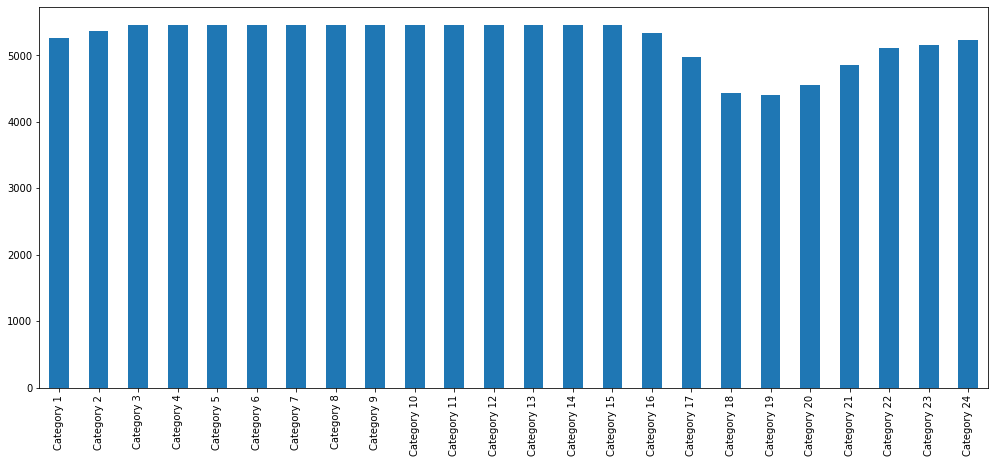

In [7]:
# 有rating的數量
training_set_count = (training_set != 0.0).astype(int).sum(axis=0)
plt.figure(figsize = (17,7))
training_set_count.plot.bar()

# 算術平均數

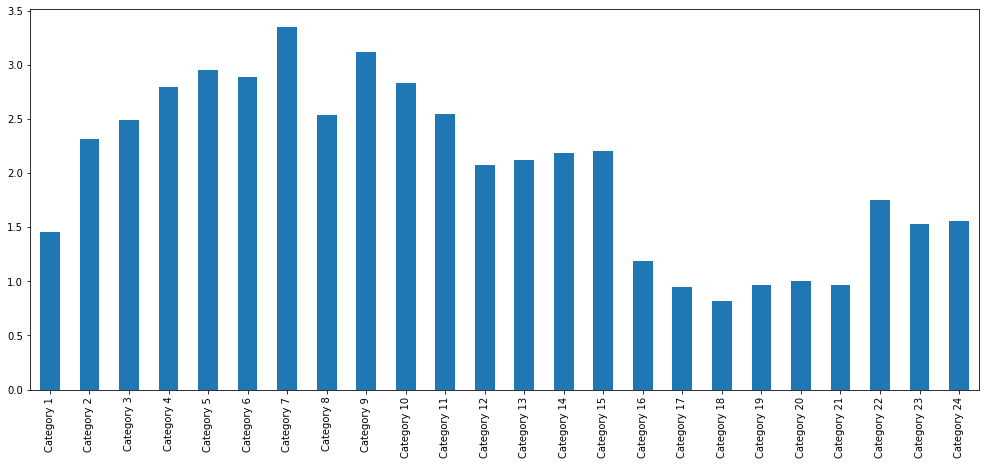

In [8]:
# 算術平均數
training_set_mean = training_set.mean()
plt.figure(figsize = (17,7))
training_set_mean.plot.bar()

# 相關矩陣

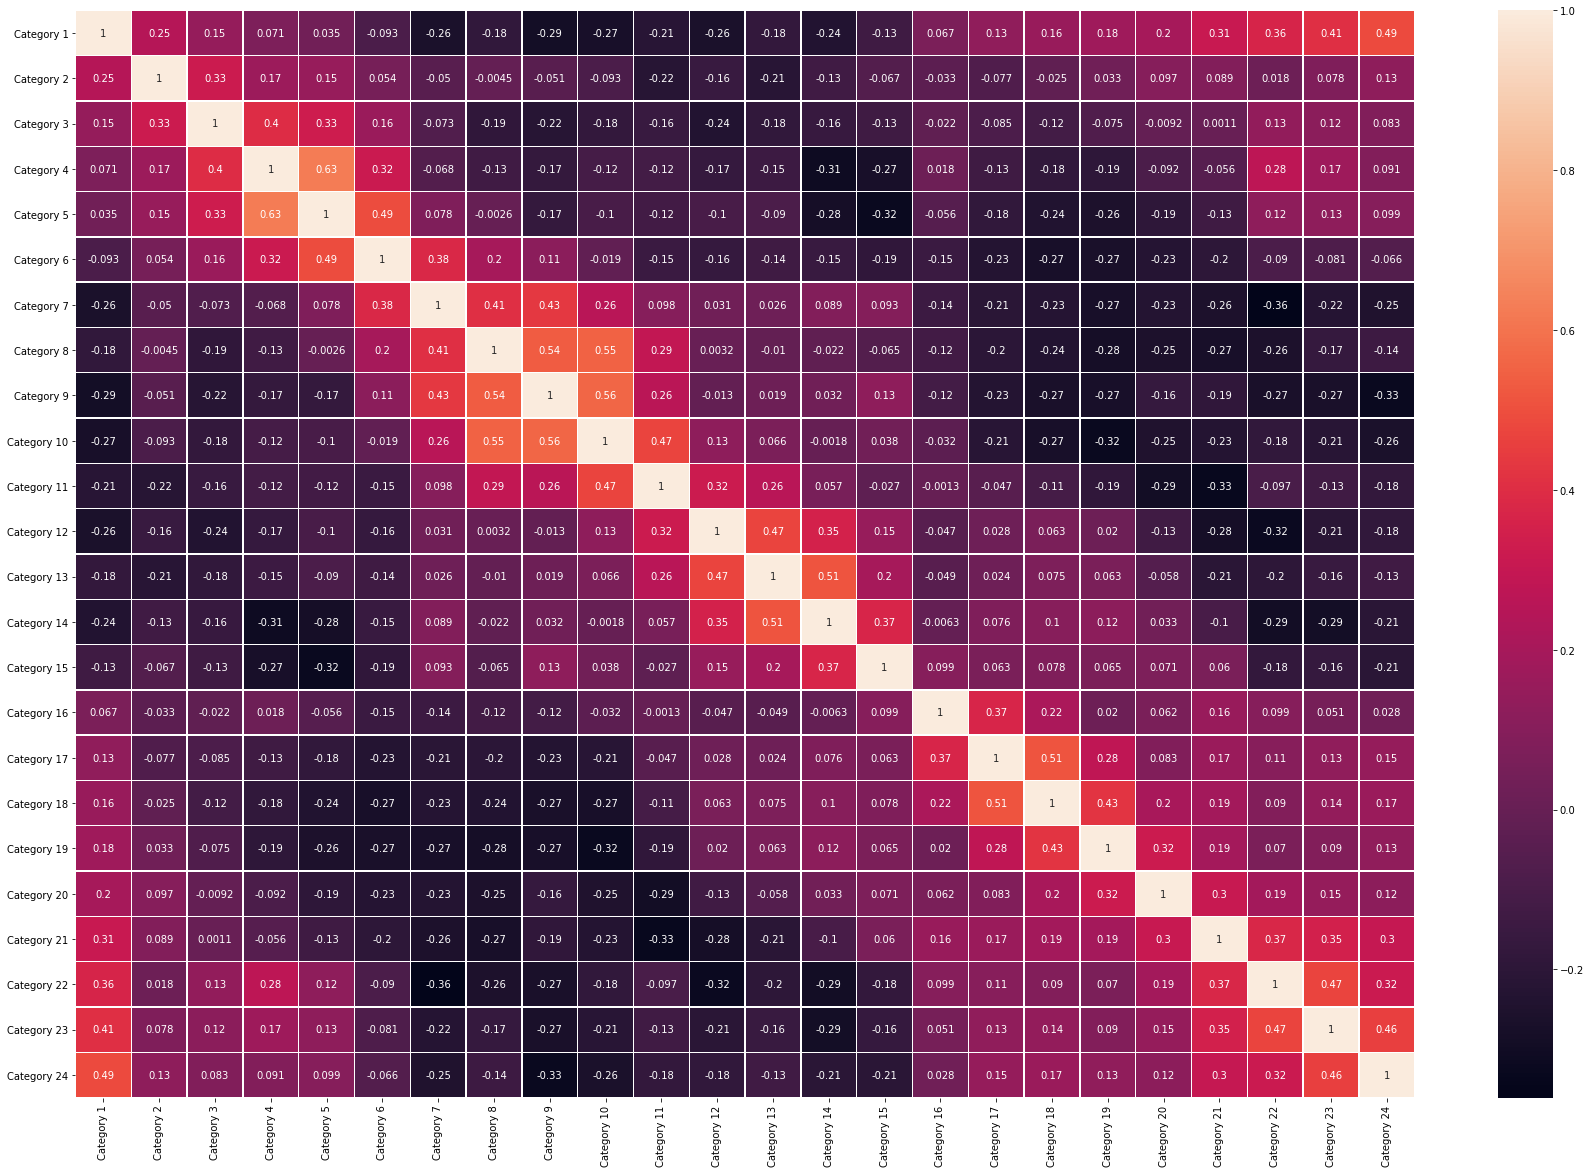

In [9]:
# 相關矩陣
corr_Matrix = training_set.corr()
plt.figure(figsize = (30,20))
sn.heatmap(corr_Matrix, annot_kws={"size": 10} ,annot=True, linewidths=0.5)
plt.show()

# 所有模型

# 第一部分的Code是dendrogram，第二部分是DBSCAN，最後是優化的DBSCAN。



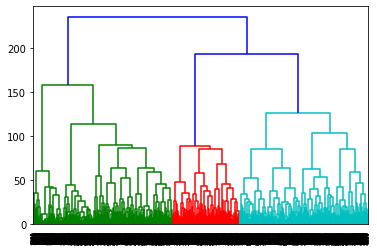

In [0]:
# 第一部分- dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

np_mat = training_set.values
Z = linkage(np_mat, 'ward')
dendrogram(Z)
plt.show()

[[0.    0.    0.726 ... 0.    0.    0.   ]
 [0.    0.    0.726 ... 0.    0.    0.   ]
 [0.    0.    0.726 ... 0.    0.    0.   ]
 ...
 [0.188 1.    0.806 ... 1.    1.    0.222]
 [0.19  0.81  0.81  ... 1.    1.    0.224]
 [0.19  0.814 1.    ... 1.    1.    0.234]]
總共有 85 個cluster
cluster  0 : 12
cluster  1 : 16
cluster  2 : 11
cluster  3 : 113
cluster  4 : 11
cluster  5 : 16
cluster  6 : 56
cluster  7 : 61
cluster  8 : 88
cluster  9 : 442
cluster  10 : 40
cluster  11 : 29
cluster  12 : 59
cluster  13 : 19
cluster  14 : 52
cluster  15 : 61
cluster  16 : 78
cluster  17 : 11
cluster  18 : 25
cluster  19 : 19
cluster  20 : 17
cluster  21 : 179
cluster  22 : 167
cluster  23 : 16
cluster  24 : 19
cluster  25 : 15
cluster  26 : 30
cluster  27 : 117
cluster  28 : 12
cluster  29 : 27
cluster  30 : 20
cluster  31 : 17
cluster  32 : 57
cluster  33 : 24
cluster  34 : 27
cluster  35 : 35
cluster  36 : 13
cluster  37 : 19
cluster  38 : 18
cluster  39 : 17
cluster  40 : 10
cluster  41 : 2
cluster  42 

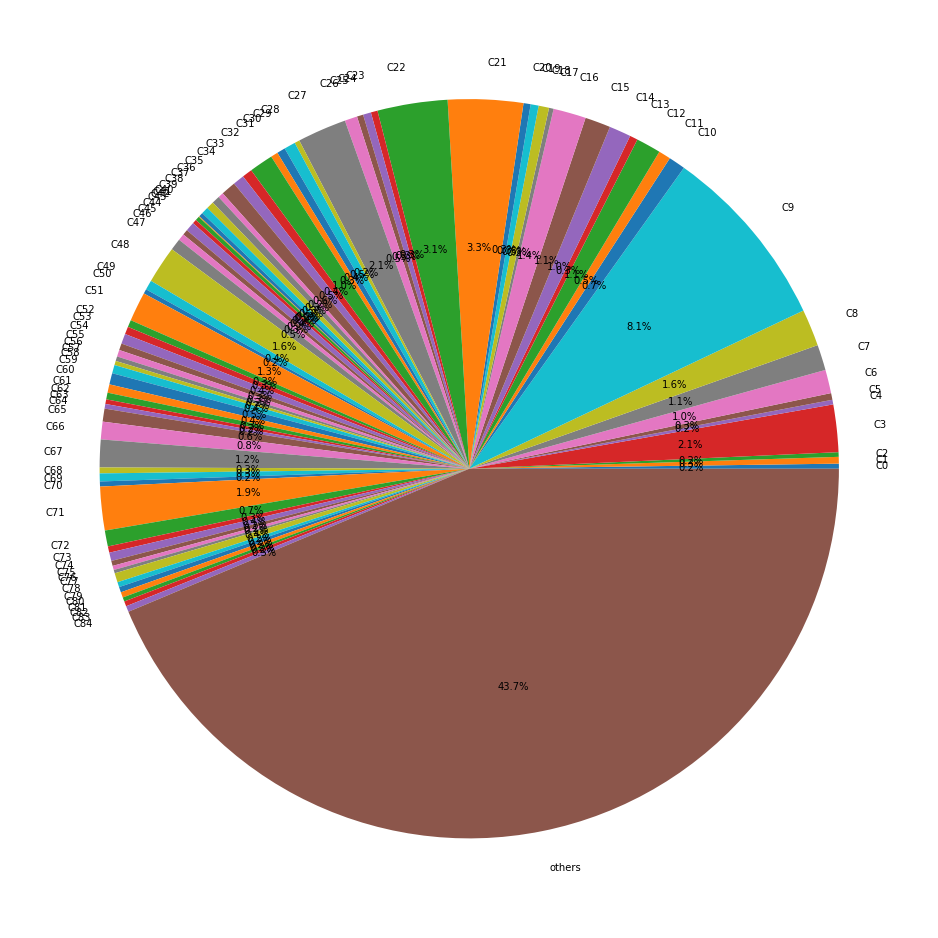

In [10]:
# 第二部分- DBSCAN
from sklearn.cluster import DBSCAN

# 將資料範圍限制在[0,1]之間
np_mat = training_set.values/5
print(np_mat)

# DBSCAN模型
model = DBSCAN(eps = 0.5, min_samples = 10)

# 開始計算
model.fit(np_mat)

num_clusters = len(set(model.labels_)) - 1
print("總共有",num_clusters, "個cluster")

# 開始計算每個clusters中含有多少人
clusters = {}
labels = model.labels_
pie_value=[]
pie_keys=[]

for i in range(-1,num_clusters):
  clusters[str(i)] = 0

for j in labels:
  clusters[str(j)] += 1

for i in range(0,num_clusters):
  print("cluster ",i,":",clusters[str(i)])
  pie_value.append(int(clusters[str(i)]))
  pie_keys.append("C"+str(i))


print("outliers:",clusters[str(-1)])
pie_value.append(int(clusters[str(-1)]))
pie_keys.append("others")

plt.figure(figsize = (17,17))
plt.pie(pie_value,labels=pie_keys,autopct='%1.1f%%')
plt.show()

[[0.    0.    0.726 ... 0.    0.    0.   ]
 [0.    0.    0.726 ... 0.    0.    0.   ]
 [0.    0.    0.726 ... 0.    0.    0.   ]
 ...
 [0.188 1.    0.806 ... 1.    1.    0.222]
 [0.19  0.81  0.81  ... 1.    1.    0.224]
 [0.19  0.814 1.    ... 1.    1.    0.234]]
總共有 73 個cluster
cluster  0 : 2981
cluster  1 : 11
cluster  2 : 7
cluster  3 : 22
cluster  4 : 8
cluster  5 : 15
cluster  6 : 9
cluster  7 : 9
cluster  8 : 8
cluster  9 : 5
cluster  10 : 25
cluster  11 : 9
cluster  12 : 32
cluster  13 : 35
cluster  14 : 86
cluster  15 : 5
cluster  16 : 33
cluster  17 : 9
cluster  18 : 12
cluster  19 : 8
cluster  20 : 9
cluster  21 : 6
cluster  22 : 81
cluster  23 : 7
cluster  24 : 8
cluster  25 : 90
cluster  26 : 91
cluster  27 : 5
cluster  28 : 588
cluster  29 : 5
cluster  30 : 35
cluster  31 : 5
cluster  32 : 36
cluster  33 : 11
cluster  34 : 16
cluster  35 : 13
cluster  36 : 7
cluster  37 : 10
cluster  38 : 6
cluster  39 : 13
cluster  40 : 13
cluster  41 : 9
cluster  42 : 13
cluster  43 : 6


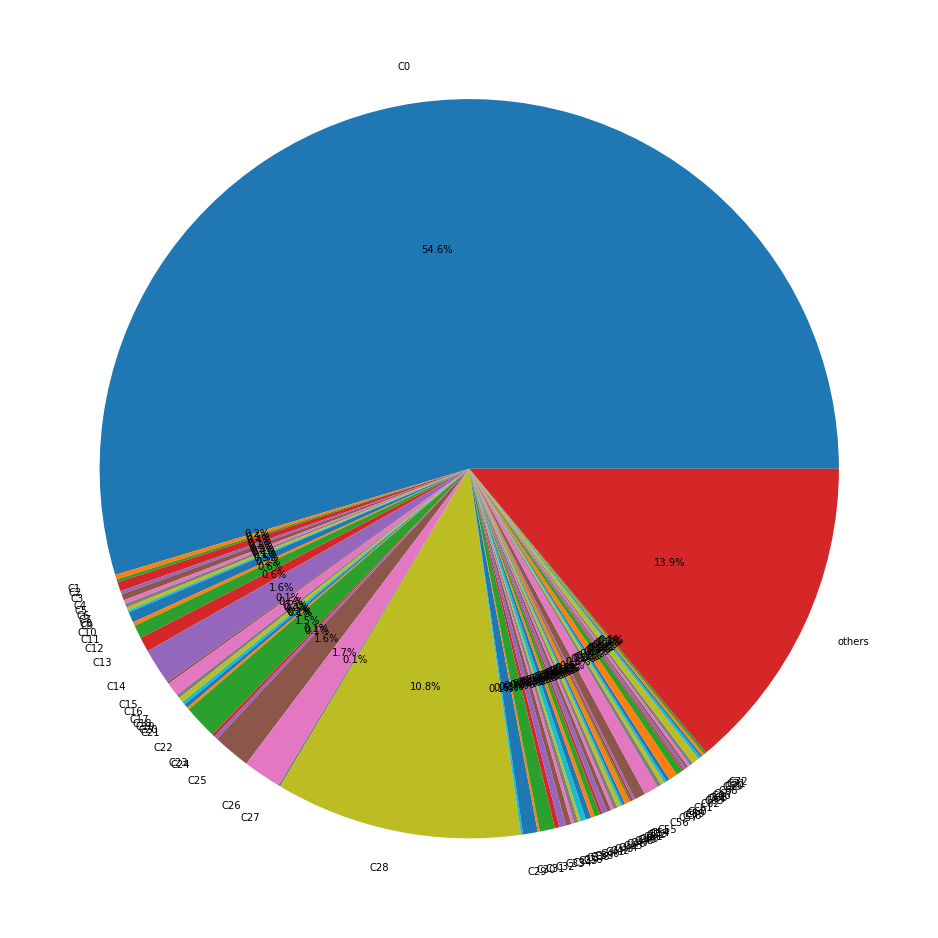

In [11]:
# 第三部分- 優化DBSCAN
from sklearn.cluster import DBSCAN

# 將資料範圍限制在[0,1]之間
np_mat = training_set.values/5
print(np_mat)

# DBSCAN模型
model = DBSCAN(eps = 0.65, min_samples = 5)

# 開始計算
model.fit(np_mat)

num_clusters = len(set(model.labels_)) - 1
print("總共有",num_clusters, "個cluster")

# 開始計算每個clusters中含有多少人
clusters = {}
labels = model.labels_
pie_value=[]
pie_keys=[]

for i in range(-1,num_clusters):
  clusters[str(i)] = 0

for j in labels:
  clusters[str(j)] += 1

for i in range(0,num_clusters):
  print("cluster ",i,":",clusters[str(i)])
  pie_value.append(int(clusters[str(i)]))
  pie_keys.append("C"+str(i))


print("outliers:",clusters[str(-1)])
pie_value.append(int(clusters[str(-1)]))
pie_keys.append("others")

plt.figure(figsize = (17,17))
plt.pie(pie_value,labels=pie_keys,autopct='%1.1f%%')
plt.show()

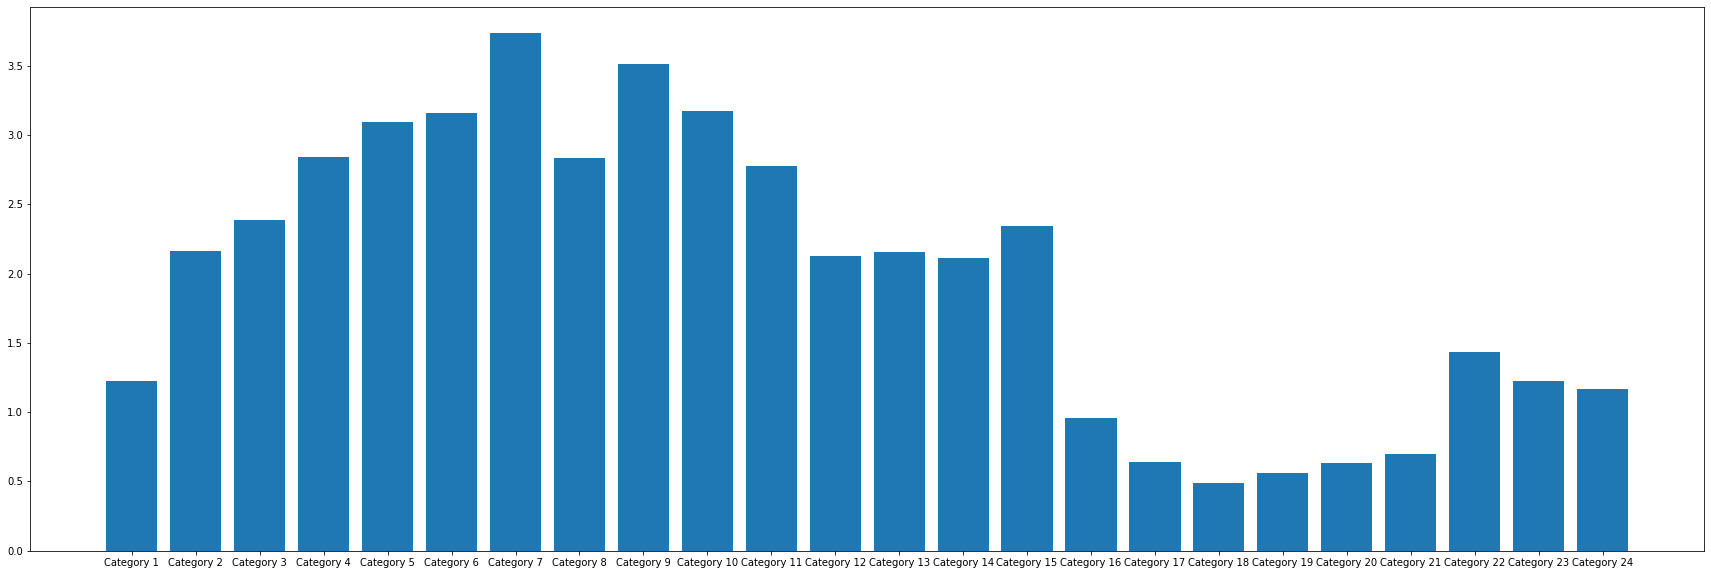

In [50]:
# temp_cluster_0是用來算最大cluster的平均rating
temp_cluster_0 = training_set.values[0] * 0 #init
for j in range(0,len(labels)):
  if labels[j] == 0:
    temp_cluster_0 += training_set.values[j]
result_cluster_0 = temp_cluster_0/clusters['0']

# 印出圖形
plt.figure(figsize = (30,10))
plt.bar(training_set.columns,result_cluster_0)
plt.show()

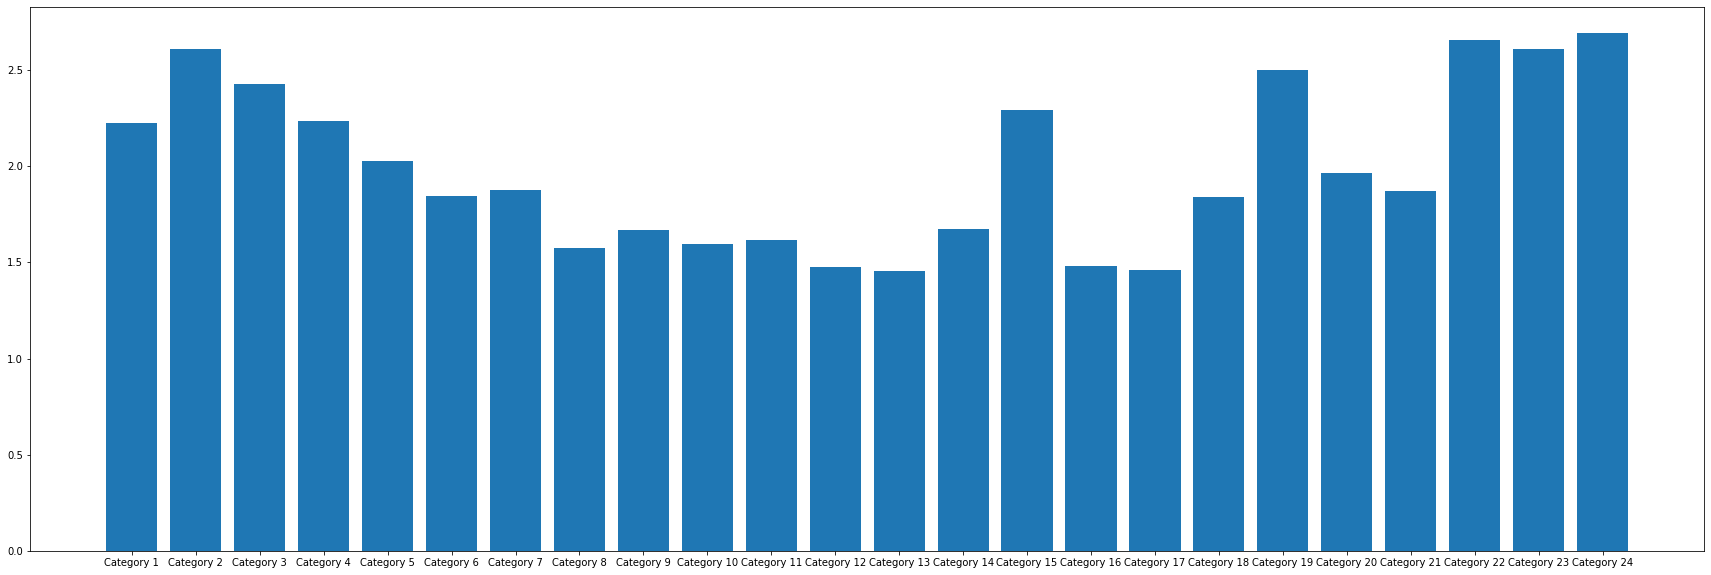

In [39]:
# temp_cluster_28是用來算第2大cluster的平均rating
temp_cluster_28 = training_set.values[0] * 0 #init
for j in range(0,len(labels)):
  if labels[j] == 28:
    temp_cluster_28 += training_set.values[j]
result_cluster_28 = temp_cluster_28/clusters['28']

# 印出圖形
plt.figure(figsize = (30,10))
plt.bar(training_set.columns,result_cluster_28)
plt.show()

In [31]:
EXECUTION_END_TIME = time.time() # 計算執行時間
print('total execution time: {}'.format(EXECUTION_END_TIME - EXECUTION_START_TIME))

total execution time: 1520.7500228881836
